In [1]:
import sys
sys.path.append('..')

from ml.dataset.corpus import *
from ml.dataset.mappers_preprocess import *
from ml.dataset.mappers_simplify import *
from ml.dataset.mappers_prepare import *
from ml.dataset.processor import *
from ml.dataset.pipeline import *
from IPython.core.display import HTML, display

import matplotlib.pyplot as plt
import pandas as pd
import pychord
import music21
music21.environment.set('musescoreDirectPNGPath', '/usr/bin/musescore')

In [2]:
X = np.load('../simple_dataset/X.npy')
y = np.load('../simple_dataset/y.npy')

In [3]:
from sklearn.preprocessing import LabelEncoder


In [4]:
X_cat_mask = np.array([type(val) == str for val in X[0]])
X_num_mask = np.logical_not(X_cat_mask)

In [5]:
X_cat = X[:, X_cat_mask]
X_num = X[:, X_num_mask]

In [6]:
X_cat.shape, y.shape

((135674, 8), (135674, 8))

In [7]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(np.hstack([X_cat.flatten(), y.flatten()]))
print(enc.classes_)
for i in range(sum(X_cat_mask)):
    X_cat[:, i] = enc.transform(X_cat[:, i])
    y[:, i] = enc.transform(y[:, i])

['' '-' 'A' 'B-' 'C' 'D' 'E' 'E-' 'F' 'G']


In [8]:
X = np.hstack([X_cat, X_num])

In [9]:
y = y.astype(np.int64)

In [10]:
X = X.astype(np.int64)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nottingham_test import custom_scorers
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
#abs_dist_score = make_scorer(custom_scorers.chords_dist_error)
y_pred = clf.predict(X_test).astype(np.int64)

In [14]:
y_true = y_test

In [15]:
np.hstack([y_true, y_pred]).shape

(33919, 16)

In [16]:
def equal_over_axis(y_true, y_pred, axis=1):
    def process(row):
        true_row = row[:y_true.shape[1]]
        pred_row = row[y_true.shape[1]:]
        return np.array_equal(true_row, pred_row)
    return np.apply_along_axis(process, axis, np.hstack([y_true, y_pred]))
def accuracy_over_axis(y_test, y_pred, axis=1):
    return sum(equal_over_axis(y_test, y_pred, 1))/y_pred.shape[np.abs(1-axis)]

In [17]:
print(accuracy_over_axis(y_test, y_pred))
#print(abs_dist_score(clf, X_test, y_test))

0.6549426575075916


In [63]:
y_pred

array([[ 9,  9,  9, ..., 10,  9,  9],
       [ 2,  1,  8, ...,  1,  1,  1],
       [ 2,  1,  1, ...,  1,  1,  1],
       ...,
       [ 4,  1,  1, ...,  1,  1,  1],
       [11,  1,  1, ...,  1,  1,  1],
       [ 7,  0,  7, ...,  1, 11,  0]])

In [18]:
with open('../simple_dataset/rf.pickle', 'wb') as fid:
    pickle.dump(clf, fid)

In [19]:
corpus = SongCorpus()
corpus.load_from_file('../simple_dataset/simple_dataset_SimplifyChordsMapper_beatles.pickle')

In [38]:
corpus6 = SongCorpus()

corpus6.pipeline.mappers = \
[ClassifyChordsMapper()]
corpus6.load_from_file('../simple_dataset/simple_dataset_SimplifyChordsMapper.pickle')
corpus6.apply_pipeline_to_memory()

{}

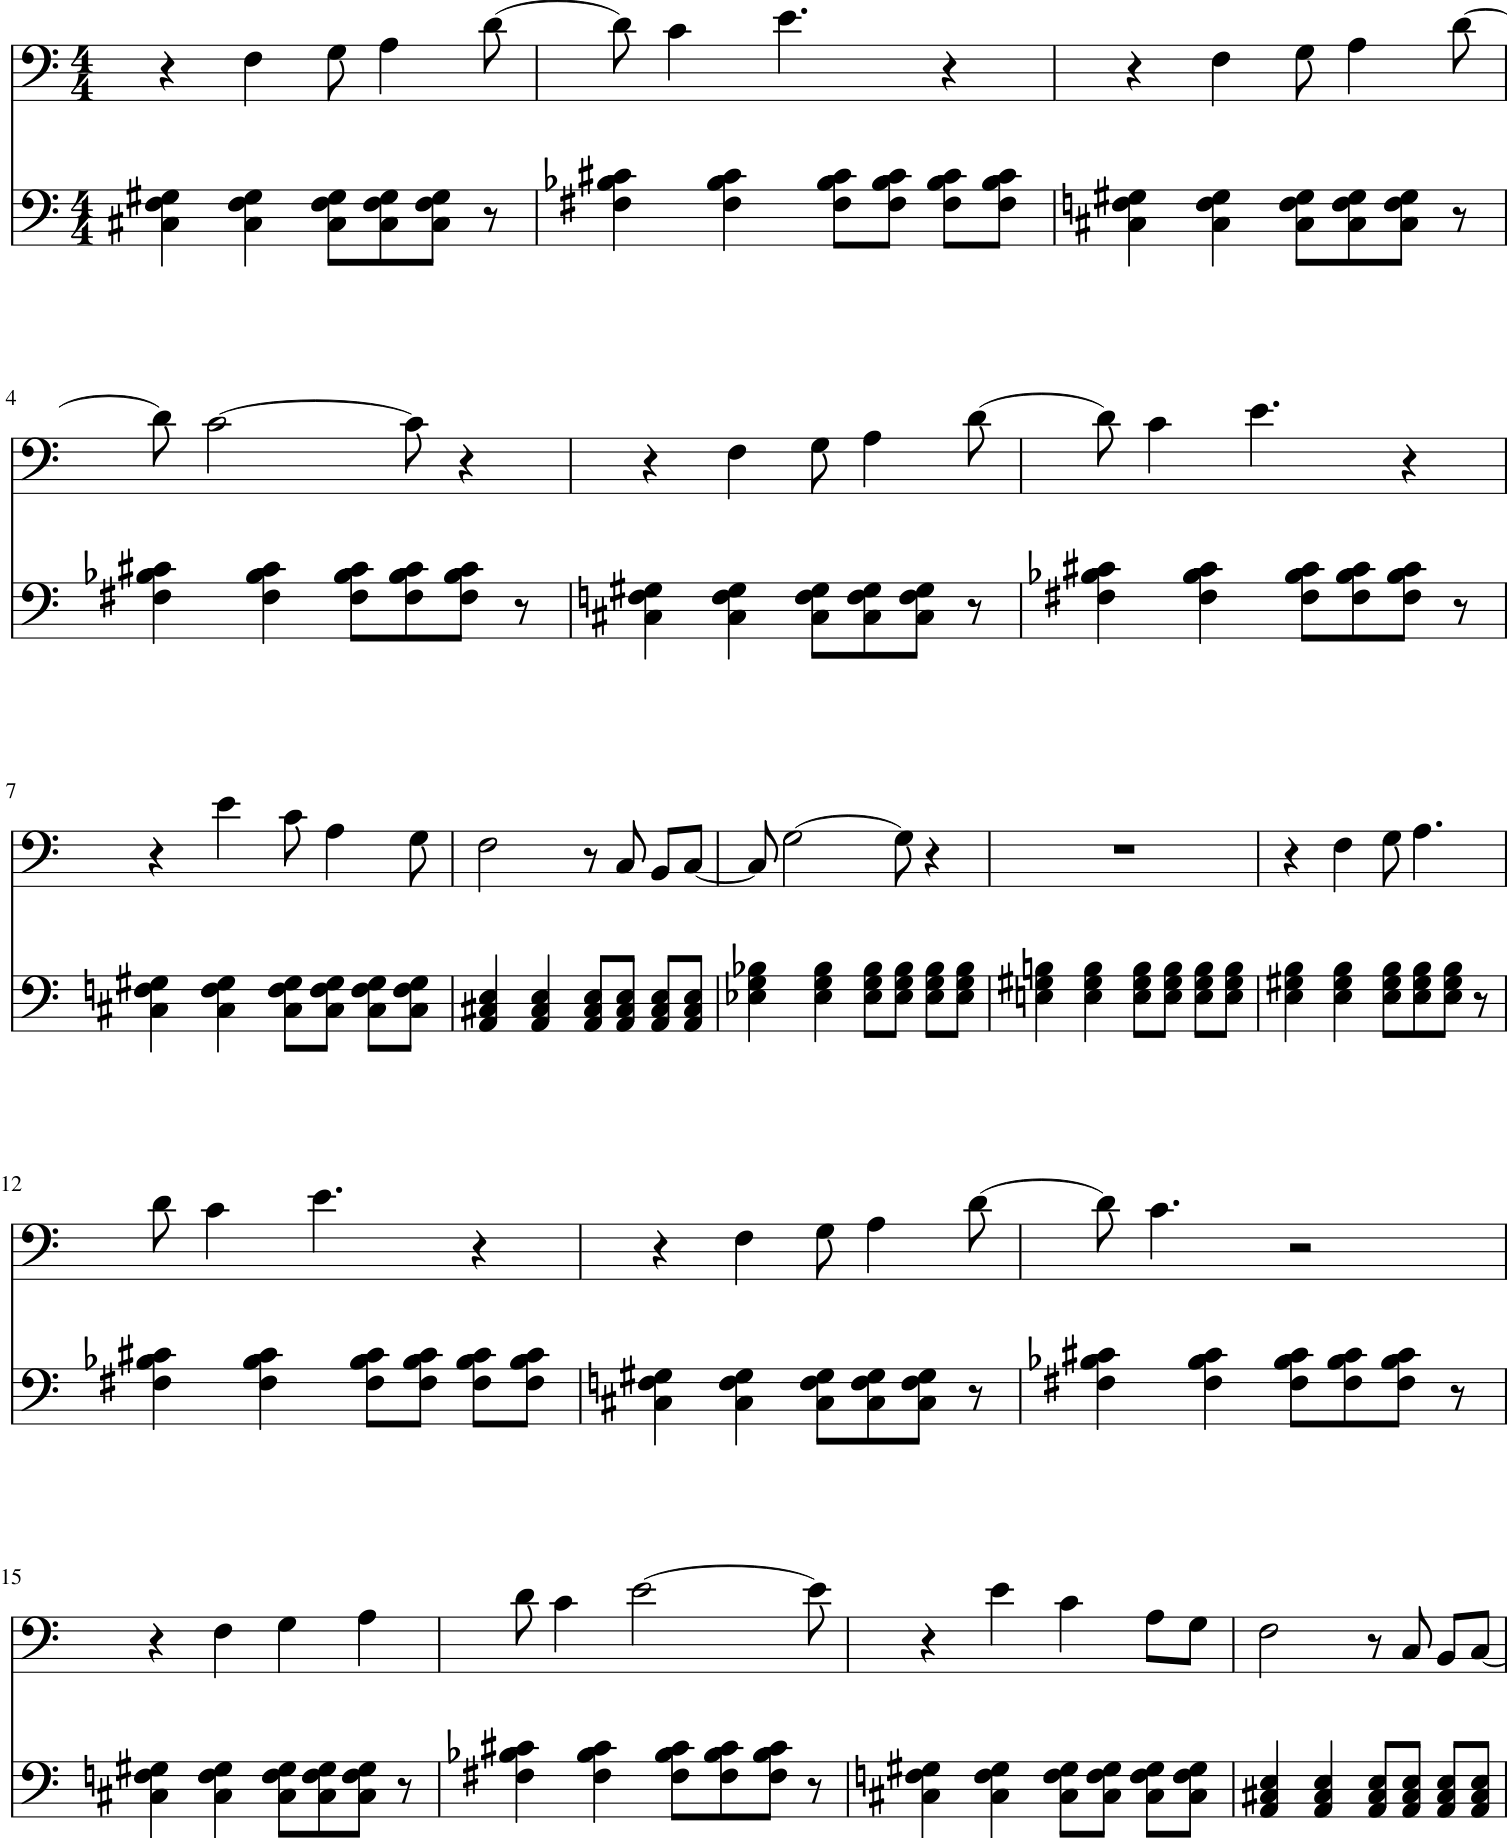

In [49]:
corpus.songs[0].get_music21_repr().show()

In [50]:
def predict_song(song_c,     preview=1, measure_length = 8):
    ccm = corpus6.pipeline.mappers[0]
    song = ccm.process(song_c)[0]
    
    predicted = []
    for i in range(preview, len(song[0])//measure_length-1):
        # melody history + chords history + current melody
        x = np.array(song[0][(i-preview)*measure_length:i*measure_length] + \
            song[1][(i-preview)*measure_length:i*measure_length])
        # current chords
        y = np.array(song[1][i*measure_length:(i+1)*measure_length] )
        #print(x, y, X_cat_mask)
        x_cat = x[X_cat_mask]
        x_num = x[X_num_mask]
        for i in range(sum(X_cat_mask)):
            x_cat[i] = enc.transform([x_cat[i]])[0]
            y[i] = enc.transform([y[i]])[0]
        x = np.hstack([x_num, x_cat])
        
        y_pred = clf.predict([x]).astype(np.int64)[0]
        predicted += list(enc.inverse_transform(y_pred))
    
    print(ccm.reverse_chord_to_root_dict)
    predicted_song = ccm.inverse_process([[], predicted])
    predicted_song.tracks[0] = song_c.tracks[0]
    return predicted_song

In [51]:
predicted_song = predict_song(corpus.songs[0])

{'B-': (54, 58, 61), 'C': (56, 60, 63), 'A': (45, 49, 52), 'G': (55, 59, 62), 'E-': (47, 51, 54), 'F': (49, 53, 56), 'D': (50, 54, 57), 'E': (52, 56, 59)}


/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprecatio

In [53]:
predicted_song.get_music21_repr().show('midi')

In [54]:
predicted_song.get_music21_repr().write('midi', fp='../simple_dataset/predicted_song.mid')

'/home/sharik/code/Innprak/simple_dataset/predicted_song.mid'